<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Azure Machine Learning Studio engine

This notebook shows how to monitor the designer based endpoints deployed on Azure Machine Learning Studio using Watson OpenScale python sdk.

<!-- **Note:** This notebook works correctly with kernel **`IBM Runtime 22.1 on Python 3.10 XS`** if using IBM Watson Studio or else use standard Python 3.10 runtime. -->

Contents

1. [Setup](#setup)
2. [Binding machine learning engine](#binding)
3. [Subscriptions](#subsciption)
4. [Performance monitor, scoring and payload logging](#scoring)
5. [Quality monitor and feedback logging](#feedback)
6. [Drift monitor and explainability](#monitors)

<a id="setup"></a>
# 1. Setup

### Sample model creation using [Azure Machine Learning Studio](https://ml.azure.com/)

- Create a [training pipeline](https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-designer-automobile-price-train-score?view=azureml-api-1) in the designer studio and run the job

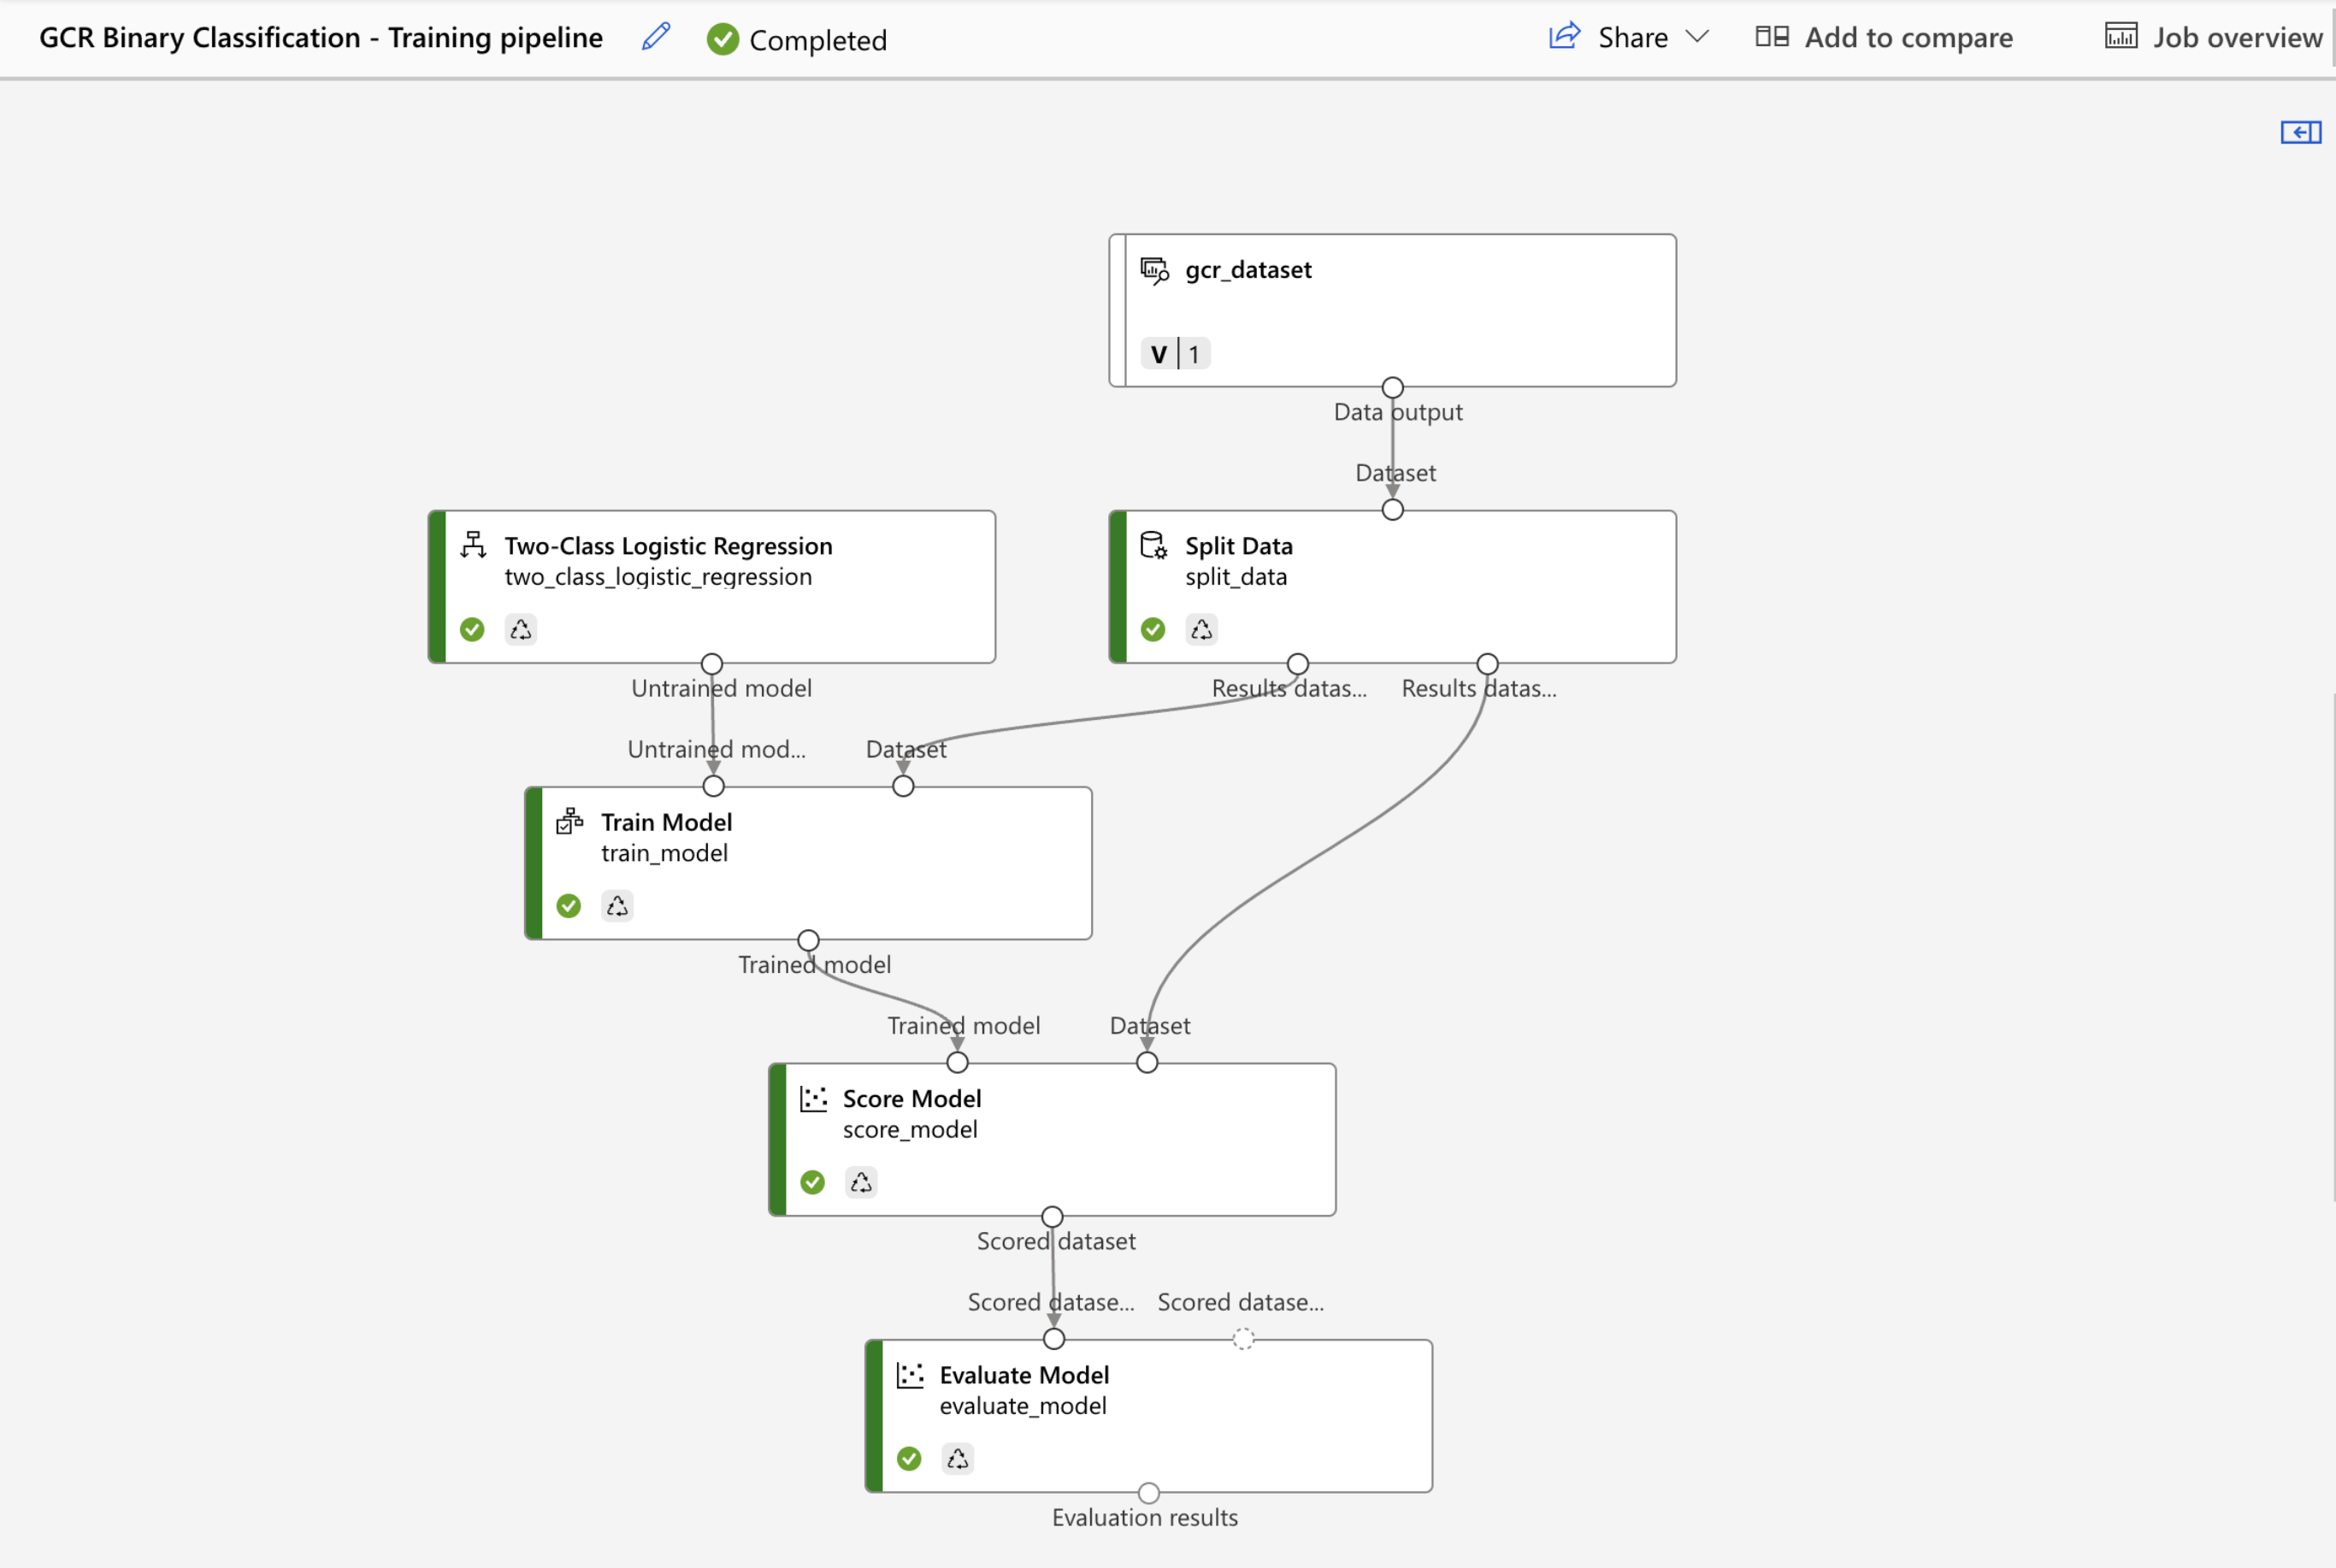
- Create the [real-time inference pipeline](https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-designer-automobile-price-deploy?view=azureml-api-1) from the training pipeline job

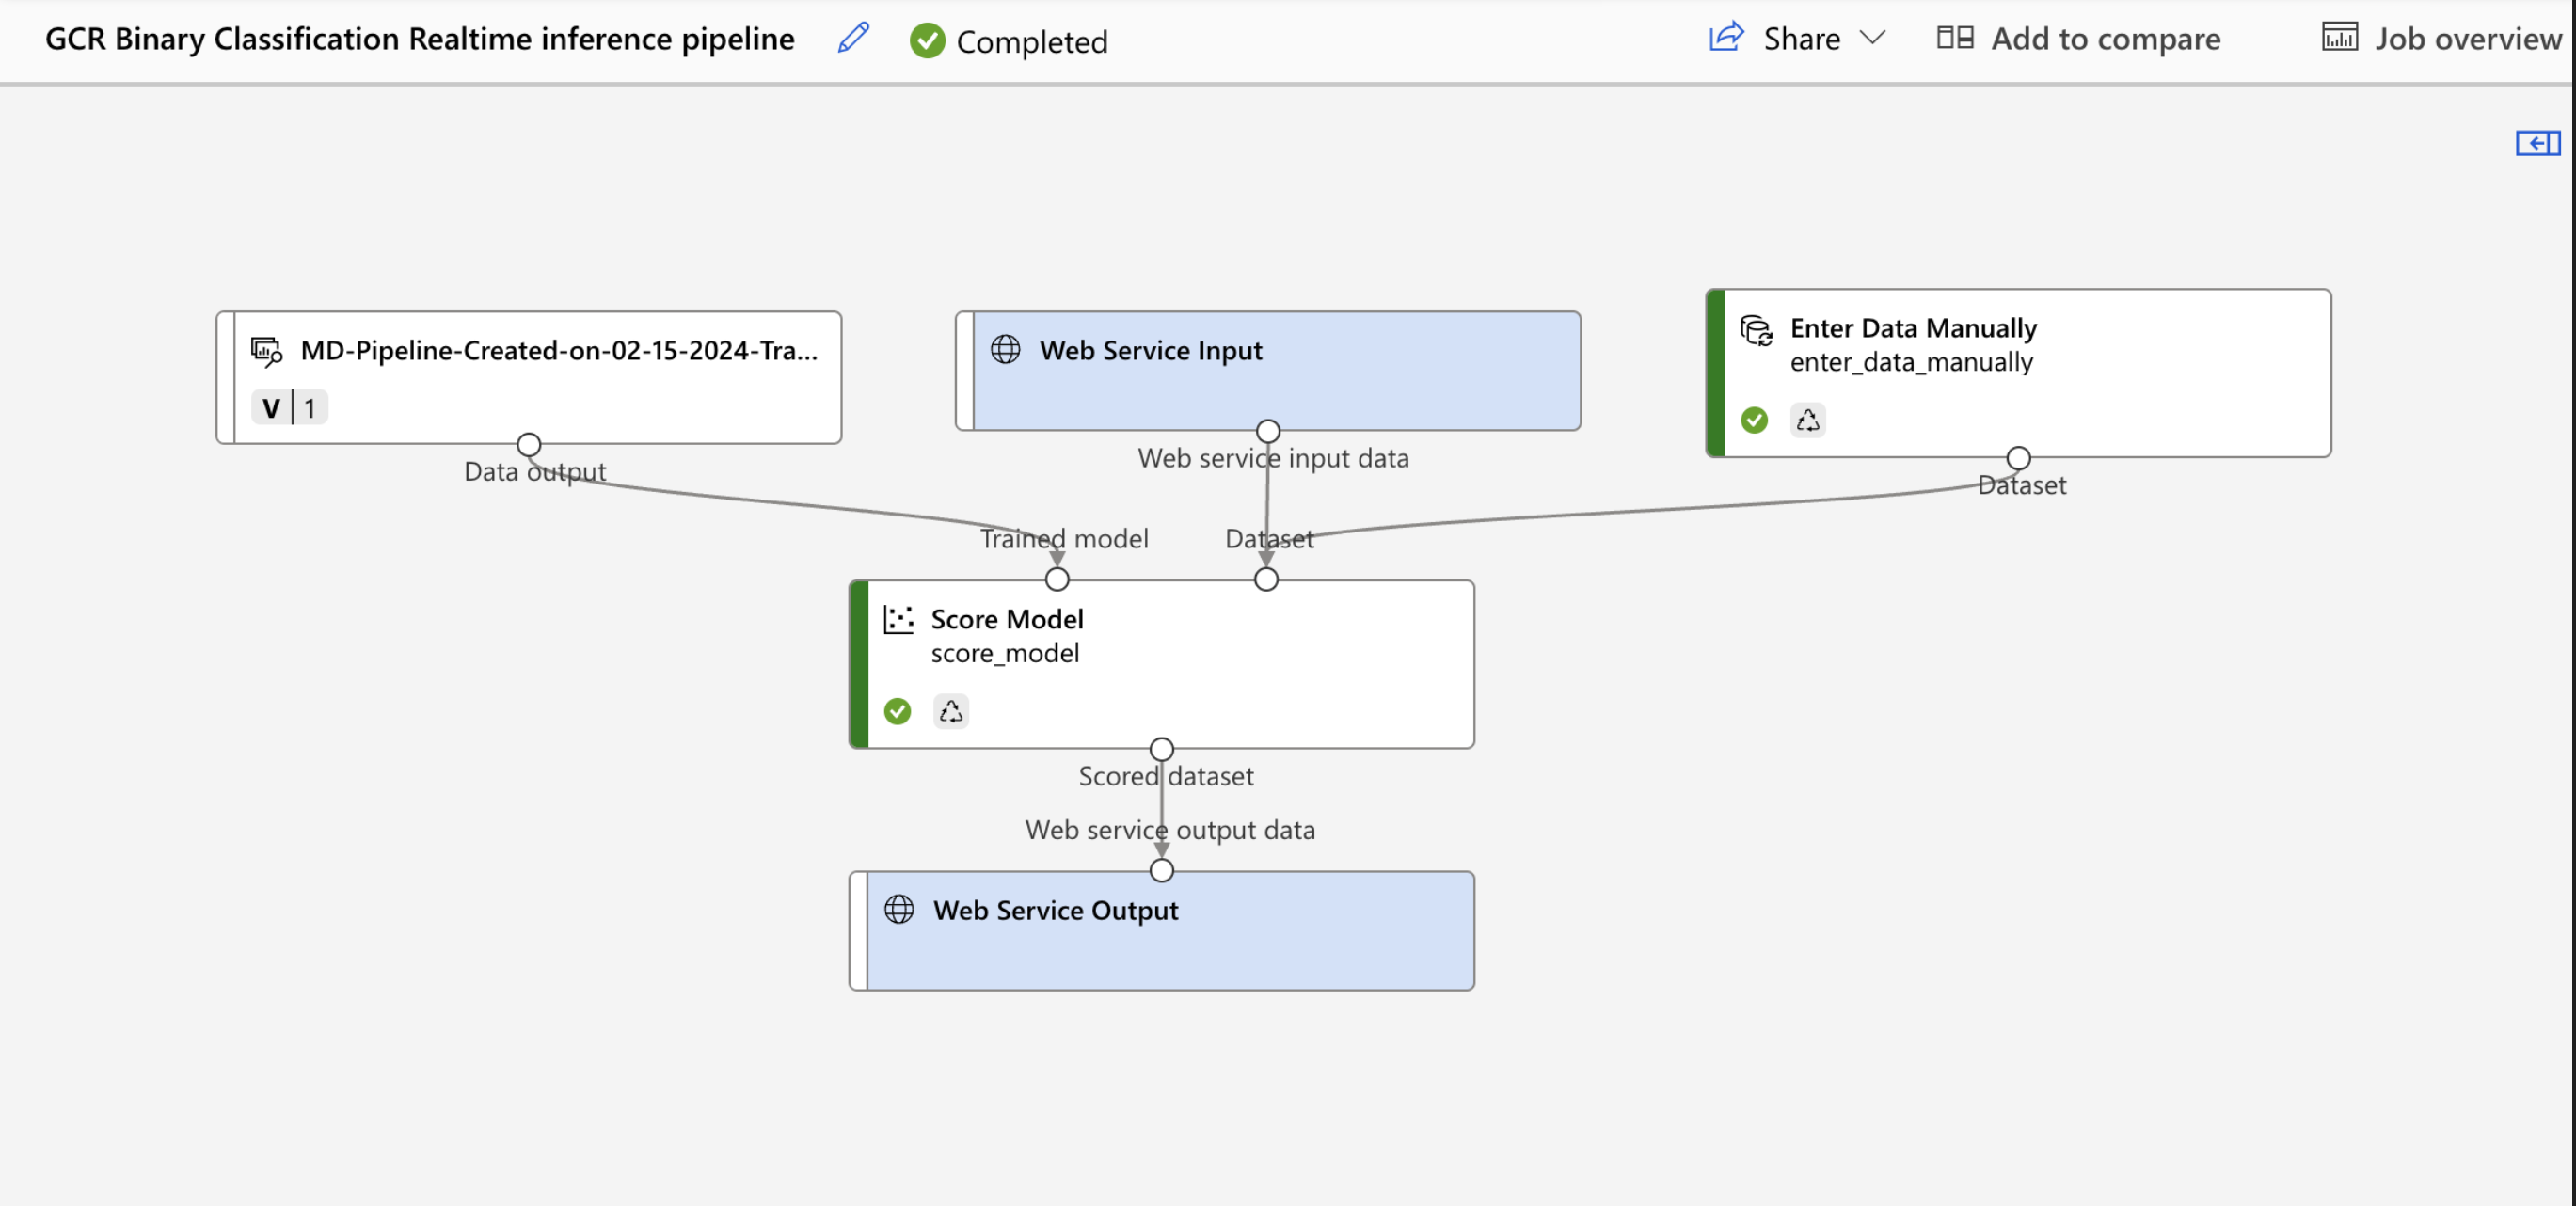

- Deploy the model from the inference pipeline job as real-time endpoint


### Installation and authentication

In [1]:
# !pip install --upgrade --upgrade ibm-watson-openscale==3.0.39 --no-cache | tail -n 1
# !pip install --upgrade lime --no-cache | tail -n 1

**Action:** Restart the kernel (Kernel->Restart)

#### ACTION: Get Watson OpenScale `apikey`

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [2]:
CLOUD_API_KEY = '<EDIT THIS>'

In [3]:
DB_CREDENTIALS=None
#DB_CREDENTIALS= {"hostname":"","username":"","password":"","database":"","port":"","ssl":True,"sslmode":"","certificate_base64":""}

In [4]:
SCHEMA_NAME = 'azure_dm'

In [5]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

authenticator = IAMAuthenticator(apikey=CLOUD_API_KEY)
#authenticator = BearerTokenAuthenticator(bearer_token=IAM_TOKEN) ## uncomment if using IAM token

wos_client = APIClient(authenticator=authenticator)

wos_client.version

'3.0.39'

#### Download and preview training data set

In [6]:
!rm -rf credit_risk_training.csv
!wget "https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/credit_risk/credit_risk_training.csv"

In [7]:
import pandas as pd
import json

training_data_pd = pd.read_csv(
        "credit_risk_training.csv",
        dtype={'LoanDuration': int, 'LoanAmount': int, 'InstallmentPercent': int, 'CurrentResidenceDuration': int, 'Age': int, 'ExistingCreditsCount': int, 'Dependents': int})

In [8]:
training_data_pd.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


## Save training data to IBM Cloud Object Storage

In next cells, you will need to paste some credentials to Cloud Object Storage. If you haven't worked with COS yet please visit getting started with COS tutorial. You can find COS_API_KEY_ID and COS_RESOURCE_CRN variables in Service Credentials in menu of your COS instance. Used COS Service Credentials must be created with Role parameter set as Writer. Later training data file will be loaded to the bucket of your instance and used as training refecence in subsription. COS_ENDPOINT variable can be found in Endpoint field of the menu.

In [9]:
IAM_URL=""

In [10]:
COS_API_KEY_ID = ""
COS_RESOURCE_CRN = "" # eg "crn:v1:bluemix:public:cloud-object-storage:global:a/3bf0d9003abfb5d29761c3e97696b71c:d6f04d83-6c4f-4a62-a165-696756d63903::"
COS_ENDPOINT = "" # Current list avaiable at https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints

In [11]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError

cos_client = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [12]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError

cos_client = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint="",
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [13]:
with open(training_data_file_name, "rb") as file_data:
    cos_client.Object(BUCKET_NAME, training_data_file_name).upload_fileobj(
        Fileobj=file_data
    )

### DataMart setup

In [14]:
wos_client.data_marts.show()

AIOSFASTPATHYS1DEV-01089354-4690-4933-B62A-410112B16405,None,True,active,2024-05-04 16:49:41.734000+00:00,01089354-4690-4933-b62a-410112b16405


In [15]:
data_marts = wos_client.data_marts.list().result.data_marts
if len(data_marts) == 0:
    if DB_CREDENTIALS is not None:
        if SCHEMA_NAME is None: 
            print("Please specify the SCHEMA_NAME and rerun the cell")

        print('Setting up external datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook",
                database_configuration=DatabaseConfigurationRequest(
                  database_type=DatabaseType.POSTGRESQL,
                    credentials=PrimaryStorageCredentialsLong(
                        hostname=DB_CREDENTIALS['hostname'],
                        username=DB_CREDENTIALS['username'],
                        password=DB_CREDENTIALS['password'],
                        db=DB_CREDENTIALS['database'],
                        port=DB_CREDENTIALS['port'],
                        ssl=True,
                        sslmode=DB_CREDENTIALS['sslmode'],
                        certificate_base64=DB_CREDENTIALS['certificate_base64']
                    ),
                    location=LocationSchemaName(
                        schema_name= SCHEMA_NAME
                    )
                )
             ).result
    else:
        print('Setting up internal datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook", 
                internal_database = True).result
        
    data_mart_id = added_data_mart_result.metadata.id
    
else:
    data_mart_id=data_marts[0].metadata.id
    print('Using existing datamart {}'.format(data_mart_id))

Using existing datamart 01089354-4690-4933-b62a-410112b16405


<a id="binding"></a>
# 2. Bind machine learning engines

### Bind  `Azure` machine learning studio

Provide credentials using following fields:
- `client_id`
- `client_secret`
- `subscription_id`
- `tenant`

In [16]:
AZURE_ENGINE_CREDENTIALS = {
   "client_id": "<EDIT THIS>",
    "client_secret": "<EDIT THIS>",
    "subscription_id": "<EDIT THIS>",
    "tenant": "<EDIT THIS>"
}

In [17]:
SERVICE_PROVIDER_NAME = "Azure Studio Machine Learning"
SERVICE_PROVIDER_DESCRIPTION = "Added by Azure tutorial WOS notebook."

In [18]:
service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for WML instance: {}".format(service_provider_id))

Deleted existing service_provider for WML instance: adc13e01-8129-458a-af9c-22bb52de103f


In [20]:
added_service_provider_result = wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description=SERVICE_PROVIDER_DESCRIPTION,
        service_type=ServiceTypes.AZURE_MACHINE_LEARNING,
        operational_space_id = "production",
        credentials=AzureCredentials(
            subscription_id= AZURE_ENGINE_CREDENTIALS['subscription_id'], 
            client_id = AZURE_ENGINE_CREDENTIALS['client_id'], 
            client_secret= AZURE_ENGINE_CREDENTIALS['client_secret'],
            tenant = AZURE_ENGINE_CREDENTIALS['tenant']
        ),
        background_mode=False
    ).result
service_provider_id = added_service_provider_result.metadata.id




 Waiting for end of adding service provider 6d56c3cf-32e6-488a-aa32-f4dac11ab940 




active

-----------------------------------------------
 Successfully finished adding service provider 
-----------------------------------------------




In [21]:
wos_client.service_providers.show()

None,active,Azure Studio Machine Learning,azure_machine_learning,2024-07-25 14:02:04.272000+00:00,6d56c3cf-32e6-488a-aa32-f4dac11ab940
3cf8a4e9-9b57-4274-a2b0-026c863935cf,active,PROJECT_LLM Workspace,watson_machine_learning,2024-07-10 11:49:59.476000+00:00,48eb557d-7c01-42de-8a85-f5f93c7d85ba
None,active,Azure Machine Learning,azure_machine_learning,2024-07-04 06:06:54.504000+00:00,1d0c28b0-6976-4a06-9b9e-579a1078f454
None,active,Notebook Azure Studio,azure_machine_learning,2024-07-03 06:15:53.412000+00:00,d11dd82b-134c-4493-a1ba-35c35b91a05a
None,active,Azure Service,azure_machine_learning_service,2024-05-07 05:22:07.441000+00:00,03068ae0-8d0a-450d-bd53-263793b2e900
None,active,Azure Studio,azure_machine_learning,2024-05-04 16:52:42.804000+00:00,cecf6221-08fe-4ecd-aa16-eb6c70bacc11
3cf8a4e9-9b57-4274-a2b0-026c863935cf,active,WOS ExpressPath WML production binding,watson_machine_learning,2024-05-04 16:49:47.680000+00:00,645df9f7-2836-4e1c-9747-2bf1e55ae2ae


In [ ]:
asset_deployment_details = wos_client.service_providers.list_assets(data_mart_id=data_mart_id, service_provider_id=service_provider_id).result
print(json.dumps(asset_deployment_details,indent=2))

In [23]:
## select your model deployment GUID and get model asset details

deployment_id=''
for model_asset_details in asset_deployment_details['resources']:
    if model_asset_details['metadata']['guid']==deployment_id:
        break

# Sample Scoring

### **Openscale will look on to the swagger json response to construct the exact payload for the deployment provided.**

In [24]:
import requests
import time
import json

swagger_url = model_asset_details['entity']['asset']['url']
swagger_response = requests.get(url=swagger_url).json()
scoring_payload=swagger_response["definitions"]["ExecutionRequest"]["example"]

print("Scoring payload - refered from the examples in swagger json response")
print(json.dumps(scoring_payload,indent=2))


Scoring payload - refered from the examples in swagger json response
{
  "Inputs": {
    "input1": [
      {
        "CheckingStatus": "0_to_200",
        "LoanDuration": 31,
        "CreditHistory": "credits_paid_to_date",
        "LoanPurpose": "other",
        "LoanAmount": 1889,
        "ExistingSavings": "100_to_500",
        "EmploymentDuration": "less_1",
        "InstallmentPercent": 3,
        "Sex": "female",
        "OthersOnLoan": "none",
        "CurrentResidenceDuration": 3,
        "OwnsProperty": "savings_insurance",
        "Age": 32,
        "InstallmentPlans": "none",
        "Housing": "own",
        "ExistingCreditsCount": 1,
        "Job": "skilled",
        "Dependents": 1,
        "Telephone": "none",
        "ForeignWorker": "yes"
      }
    ]
  },
  "GlobalParameters": {}
}


In [25]:
scoring_url = model_asset_details['entity']['scoring_endpoint']['url']

body = str.encode(json.dumps(scoring_payload))


token = model_asset_details['entity']['scoring_endpoint']['credentials']['token']
headers = model_asset_details['entity']['scoring_endpoint']['request_headers']
headers['Authorization'] = ('Bearer ' + token)

start_time = time.time()
response = requests.post(url=scoring_url, data=body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

print(json.dumps(result, indent=2))

{
  "Results": {
    "WebServiceOutput0": [
      {
        "CheckingStatus": "0_to_200",
        "LoanDuration": 31,
        "CreditHistory": "credits_paid_to_date",
        "LoanPurpose": "other",
        "LoanAmount": 1889,
        "ExistingSavings": "100_to_500",
        "EmploymentDuration": "less_1",
        "InstallmentPercent": 3,
        "Sex": "female",
        "OthersOnLoan": "none",
        "CurrentResidenceDuration": 3,
        "OwnsProperty": "savings_insurance",
        "Age": 32,
        "InstallmentPlans": "none",
        "Housing": "own",
        "ExistingCreditsCount": 1,
        "Job": "skilled",
        "Dependents": 1,
        "Telephone": "none",
        "ForeignWorker": "yes",
        "Scored Labels": "No Risk",
        "Scored Probabilities": 0.07720335003150249
      }
    ]
  }
}


<a id="subsciption"></a>
# 3. Subscriptions

### Add subscriptions

List available deployments.

**Note:** Depending on number of assets it may take some time.

In [26]:
wos_client.subscriptions.show()

ba1c2f632698f29103c3e6d658339307,model,walking-activity-multiclass,01089354-4690-4933-b62a-410112b16405,29a53b253216188317bb0a8b397c2e3c,walking-activity-multiclass,cecf6221-08fe-4ecd-aa16-eb6c70bacc11,active,2024-07-14 16:37:35.201000+00:00,3944752e-82b4-4cf6-867f-4c36e1365707
894ce782-6ca7-43e8-b48a-5c2b489125d3,prompt,MCM QA Task,01089354-4690-4933-b62a-410112b16405,b6e9738b-8557-42d0-a772-ec43a973e974,MCM QA Task,48eb557d-7c01-42de-8a85-f5f93c7d85ba,active,2024-07-10 11:50:02.672000+00:00,b91a8d28-1676-402d-91e0-3a300a58a39a


In [27]:
feature_columns = ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']
categorical_columns = ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']

In [28]:
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import ScoringEndpointCredentialsAzureScoringEndpointCredentials,ScoringEndpointRequest
def get_output_schema_fields_for_azure(azure_ouput_schema, target_field, target_role = "decoded-target", field_type = str, is_nullable = True):
        fields = []
        found = False
        for field in azure_ouput_schema['fields']:
            if field['name']==target_field:
                metadata = {}
                if "metadata" in field:
                    metadata = field["metadata"]
                metadata["modeling_role"]=target_role    
                field["metadata"] = metadata
                found = True
    
            spark_field = SparkStructFieldObject(
                name=field['name'],
                type=field['type'],
                nullable=field['nullable'],
            )
            if "metadata" in field:
                spark_field.metadata = field["metadata"]
                
            fields.append(spark_field)   
        
        if found is False:
            metadata = {}
            metadata["modeling_role"] = target_role
            fields.append(SparkStructFieldObject(
                name=target_field,
                type=field_type,
                nullable=is_nullable,
                metadata = metadata
            )) 
        return fields

In [29]:
azure_asset = Asset(
            asset_id=model_asset_details["entity"]["asset"]["asset_id"],
            name=model_asset_details["entity"]["asset"]["name"],
            url=model_asset_details["entity"]["asset"]["url"],
            asset_type=AssetTypes.MODEL,
            input_data_type=InputDataType.STRUCTURED,
            problem_type=ProblemType.BINARY_CLASSIFICATION,
        )

In [30]:
deployment_scoring_endpoint = model_asset_details['entity']['scoring_endpoint']
scoring_endpoint = ScoringEndpointRequest(url = model_asset_details['entity']['scoring_endpoint']['url']
                                          ,request_headers = model_asset_details['entity']['scoring_endpoint']['request_headers'],
                                          credentials= ScoringEndpointCredentialsAzureScoringEndpointCredentials(model_asset_details['entity']['scoring_endpoint']['credentials']['token']) )

deployment = AssetDeploymentRequest(
    deployment_id=model_asset_details['metadata']['guid'],
    url=model_asset_details['metadata']['url'],
    name=model_asset_details['entity']['name'],
    description=model_asset_details['entity']['description'],
    deployment_type=model_asset_details['entity']['type'],
    scoring_endpoint = scoring_endpoint
) 

In [31]:
training_data_reference = TrainingDataReference(type='cos',
                                              location=COSTrainingDataReferenceLocation(bucket = BUCKET_NAME,
                                                                                        file_name = training_data_file_name),
                                              connection=COSTrainingDataReferenceConnection(
                                                                        resource_instance_id= COS_RESOURCE_CRN,
                                                                        url= COS_ENDPOINT,
                                                                        api_key= COS_API_KEY_ID,
                                                                        iam_url=IAM_URL)
                                               )

In [32]:
asset_properties = AssetPropertiesRequest(
        label_column="Risk",
        prediction_field='Scored Labels',
        probability_fields=['Scored Probabilities'],
        training_data_reference=training_data_reference,
        training_data_schema=None,
        feature_fields=feature_columns,
        categorical_fields=categorical_columns
    )

In [33]:
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=azure_asset,
        deployment=deployment,
        asset_properties=asset_properties,
        background_mode=False
).result
subscription_id = subscription_details.metadata.id
subscription_id




 Waiting for end of adding subscription e974d994-0f34-4e8d-93f5-ed9ce754cee1 




active

-------------------------------------------
 Successfully finished adding subscription 
-------------------------------------------




'e974d994-0f34-4e8d-93f5-ed9ce754cee1'

<a id="scoring"></a>
# 4. Scoring and payload logging

### Score the credit risk model and measure response time

In [34]:
import time

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  c552e211-756f-4ccb-b9ca-a5da46d1ff11


In [35]:
import requests
import time
import json

subscription_details=wos_client.subscriptions.get(subscription_id).result.to_dict()
scoring_url = subscription_details['entity']['deployment']['scoring_endpoint']['url']
scoring_key=list(scoring_payload["Inputs"].keys())[0]

data = { "Inputs": 
            {
                scoring_key:
                    training_data_pd.sample(2).drop(['Risk'],axis=1).to_dict('records'),
            },
            "GlobalParameters": {
            }
        }

body = str.encode(json.dumps(data))

token = model_asset_details['entity']['scoring_endpoint']['credentials']['token']
headers = subscription_details['entity']['deployment']['scoring_endpoint']['request_headers']
headers['Authorization'] = ('Bearer ' + token)

start_time = time.time()
response = requests.post(url=scoring_url, data=body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

print(json.dumps(result, indent=2))

{
  "Results": {
    "WebServiceOutput0": [
      {
        "CheckingStatus": "less_0",
        "LoanDuration": 15,
        "CreditHistory": "credits_paid_to_date",
        "LoanPurpose": "retraining",
        "LoanAmount": 2728,
        "ExistingSavings": "100_to_500",
        "EmploymentDuration": "1_to_4",
        "InstallmentPercent": 3,
        "Sex": "female",
        "OthersOnLoan": "none",
        "CurrentResidenceDuration": 3,
        "OwnsProperty": "savings_insurance",
        "Age": 35,
        "InstallmentPlans": "none",
        "Housing": "own",
        "ExistingCreditsCount": 1,
        "Job": "skilled",
        "Dependents": 1,
        "Telephone": "none",
        "ForeignWorker": "yes",
        "Scored Labels": "No Risk",
        "Scored Probabilities": 0.09587887135713216
      },
      {
        "CheckingStatus": "0_to_200",
        "LoanDuration": 5,
        "CreditHistory": "prior_payments_delayed",
        "LoanPurpose": "appliances",
        "LoanAmount": 1259,
 

## Functions to adjust payload data format for OpenScale 

In [36]:
def convert_user_input_2_openscale(input_data):
    users_records = input_data['Inputs'][scoring_key]
    openscale_fields = list(users_records[0])
    openscale_values = [[rec[k] for k in openscale_fields] for rec in users_records] 

    return {'fields':openscale_fields, 'values':openscale_values}

In [37]:
import numpy as np
def convert_user_output_2_openscale(output_data):
    users_records = output_data['Results']['WebServiceOutput0']
    openscale_fields = ["Scored Labels","Scored Probabilities"]
    openscale_values = [[np.double(rec[k]) if k=='Scored Probabilities' else rec[k] for k in openscale_fields ] for rec in users_records] 

    return {'fields':openscale_fields, 'values':openscale_values}

In [38]:
openscale_input=convert_user_input_2_openscale(data)
openscale_output=convert_user_output_2_openscale(result)

### Store the request and response in payload logging table

In [39]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord

print("Performing explicit payload logging.....")
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=[PayloadRecord(
           scoring_id=str(uuid.uuid4()),
           request=openscale_input,
           response=openscale_output,
           response_time=460
)])
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))

Performing explicit payload logging.....
Number of records in the payload logging table: 2


In [40]:
wos_client.data_sets.show_records(data_set_id=payload_data_set_id)

None,2728,53cc3d70-3cee-492d-9fca-273a79e430d9-1,3,100_to_500,2024-07-25T14:03:19.318Z,0.9041211286428679,"[0.9041211286428679, 0.09587887135713216]",less_0,retraining,0.09587887135713216,skilled,none,none,15,35,credits_paid_to_date,3,yes,own,1,193bc1c62f374e8789c9f54878af9a3f,none,No Risk,female,1,savings_insurance,1_to_4
None,1259,53cc3d70-3cee-492d-9fca-273a79e430d9-2,1,500_to_1000,2024-07-25T14:03:19.318Z,0.5096430055446993,"[0.5096430055446993, 0.49035699445530073]",0_to_200,appliances,0.49035699445530073,unskilled,stores,co-applicant,5,40,prior_payments_delayed,2,yes,own,1,193bc1c62f374e8789c9f54878af9a3f,yes,No Risk,female,1,car_other,1_to_4


<a id="feedback"></a>
# 5. Feedback logging & quality (accuracy) monitoring

### Enable quality monitoring

In [41]:
import time

time.sleep(10)
target = Target(
        target_type=TargetTypes.SUBSCRIPTION,
        target_id=subscription_id
)
parameters = {
    "min_feedback_data_size": 10
}
thresholds = [
                {
                    "metric_id": "area_under_roc",
                    "type": "lower_limit",
                    "value": .80
                }
            ]
quality_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
    target=target,
    parameters=parameters,
    thresholds=thresholds
).result




 Waiting for end of monitor instance creation c13c223c-5de7-4fb3-bacb-2292c8f040e9 




preparing
active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [42]:
quality_monitor_instance_id = quality_monitor_details.metadata.id
quality_monitor_instance_id

'c13c223c-5de7-4fb3-bacb-2292c8f040e9'

### Feedback records logging

Feedback records are used to evaluate your model. The predicted values are compared to real values (feedback records).

In [43]:
!rm additional_feedback_data_v2.json
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/credit_risk/additional_feedback_data_v2.json

### Get feedback logging dataset ID

In [44]:
feedback_dataset_id = None
feedback_dataset = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result
#print(feedback_dataset)
feedback_dataset_id = feedback_dataset.data_sets[0].metadata.id
if feedback_dataset_id is None:
    print("Feedback data set not found. Please check quality monitor status.")

In [45]:
with open('additional_feedback_data_v2.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
wos_client.data_sets.store_records(feedback_dataset_id, request_body=additional_feedback_data, background_mode=False)




 Waiting for end of storing records with request id: acd1e2b4-f8ba-42a8-a2a9-1af13d5cb42e 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------




In [46]:
# manually records scoring and store as feedback data

# records = [
#     ["no_checking","28","outstanding_credit","appliances","5990","500_to_1000","greater_7","5","male","co-applicant","3","car_other","55","none","free","2","skilled","2","yes","yes","Risk"],
#     ["greater_200","22","all_credits_paid_back","car_used","3376","less_100","less_1","3","female","none","2","car_other","32","none","own","1","skilled","1","none","yes","No Risk"],
#     ["no_checking","39","credits_paid_to_date","vacation","6434","unknown","greater_7","5","male","none","4","car_other","39","none","own","2","skilled","2","yes","yes","Risk"],
#     ["0_to_200","20","credits_paid_to_date","furniture","2442","less_100","unemployed","3","female","none","1","real_estate","42","none","own","1","skilled","1","none","yes","No Risk"],
#     ["greater_200","4","all_credits_paid_back","education","4206","less_100","unemployed","1","female","none","3","savings_insurance","27","none","own","1","management_self-employed","1","none","yes","No Risk"],
#     ["greater_200","23","credits_paid_to_date","car_used","2963","greater_1000","greater_7","4","male","none","4","car_other","46","none","own","2","skilled","1","none","yes","Risk"],
#     ["no_checking","31","prior_payments_delayed","vacation","2673","500_to_1000","1_to_4","3","male","none","2","real_estate","35","stores","rent","1","skilled","2","none","yes","Risk"],
#     ["no_checking","37","prior_payments_delayed","other","6971","500_to_1000","1_to_4","3","male","none","3","savings_insurance","54","none","own","2","skilled","1","yes","yes","Risk"],
#     ["0_to_200","39","prior_payments_delayed","appliances","5685","100_to_500","1_to_4","4","female","none","2","unknown","37","none","own","2","skilled","1","yes","yes","Risk"],
#     ["no_checking","38","prior_payments_delayed","appliances","4990","500_to_1000","greater_7","4","male","none","4","car_other","50","bank","own","2","unemployed","2","yes","yes","Risk"]]

# fields = feature_columns.copy()
# fields.append('Risk')

# payload_scoring =  [{"fields": fields, "values": records}]
# wos_client.data_sets.store_records(feedback_dataset_id, request_body=payload_scoring, background_mode=False)

In [47]:
wos_client.data_sets.get_records_count(data_set_id=feedback_dataset_id)

98

In [48]:
run_details = wos_client.monitor_instances.run(monitor_instance_id=quality_monitor_instance_id, background_mode=False).result




 Waiting for end of monitoring run c7736bc1-b215-4609-bbe4-14353194587d 




finished

---------------------------
 Successfully finished run 
---------------------------




In [49]:
time.sleep(5)
wos_client.monitor_instances.show_metrics(monitor_instance_id=quality_monitor_instance_id)

2024-07-25 14:04:41.785000+00:00,true_positive_rate,202cf44d-b14e-479c-9c6b-4c02225334b8,0.42424242424242425,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,area_under_roc,202cf44d-b14e-479c-9c6b-4c02225334b8,0.689044289044289,0.8,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,precision,202cf44d-b14e-479c-9c6b-4c02225334b8,0.8235294117647058,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,matthews_correlation_coefficient,202cf44d-b14e-479c-9c6b-4c02225334b8,0.4718894150807379,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,f1_measure,202cf44d-b14e-479c-9c6b-4c02225334b8,0.5599999999999999,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,accuracy,202cf44d-b14e-479c-9c6b-4c02225334b8,0.7755102040816326,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,label_skew,202cf44d-b14e-479c-9c6b-4c02225334b8,0.6909336273400492,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,gini_coefficient,202cf44d-b14e-479c-9c6b-4c02225334b8,0.3780885780885781,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,log_loss,202cf44d-b14e-479c-9c6b-4c02225334b8,0.4421526003056289,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:04:41.785000+00:00,false_positive_rate,202cf44d-b14e-479c-9c6b-4c02225334b8,0.046153846153846156,None,None,['model_type:original'],quality,c13c223c-5de7-4fb3-bacb-2292c8f040e9,c7736bc1-b215-4609-bbe4-14353194587d,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1


Note: First 10 records were displayed.


# 6. Drift monitoring and explanations <a id="monitors"></a>

### Explainability configuration

In [50]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result




 Waiting for end of monitor instance creation 73231c65-8857-471f-9023-1f64e8c3d7a5 




preparing.
active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [51]:
explainability_monitor_id = explainability_details.metadata.id
explainability_monitor_id

'73231c65-8857-471f-9023-1f64e8c3d7a5'

### Run explanation

In [52]:
wos_client.data_sets.show_records(data_set_id=payload_data_set_id)

None,2728,53cc3d70-3cee-492d-9fca-273a79e430d9-1,3,100_to_500,2024-07-25T14:03:19.318Z,0.9041211286428679,"[0.9041211286428679, 0.09587887135713216]",less_0,retraining,0.09587887135713216,skilled,none,none,15,35,credits_paid_to_date,3,yes,own,1,193bc1c62f374e8789c9f54878af9a3f,none,No Risk,female,1,savings_insurance,1_to_4
None,1259,53cc3d70-3cee-492d-9fca-273a79e430d9-2,1,500_to_1000,2024-07-25T14:03:19.318Z,0.5096430055446993,"[0.5096430055446993, 0.49035699445530073]",0_to_200,appliances,0.49035699445530073,unskilled,stores,co-applicant,5,40,prior_payments_delayed,2,yes,own,1,193bc1c62f374e8789c9f54878af9a3f,yes,No Risk,female,1,car_other,1_to_4


In [53]:
pl_records_resp = wos_client.data_sets.get_list_of_records(data_set_id=payload_data_set_id, limit=1, offset=0).result
scoring_ids = [pl_records_resp["records"][0]["entity"]["values"]["scoring_id"]]
print("Running explanations on scoring IDs: {}".format(scoring_ids))
explanation_types = ["lime", "contrastive"]
result = wos_client.monitor_instances.explanation_tasks(scoring_ids=scoring_ids, explanation_types=explanation_types, subscription_id=subscription_id).result
print(result)
explanation_task_id=result.to_dict()['metadata']['explanation_task_ids'][0]
explanation_task_id

Running explanations on scoring IDs: ['53cc3d70-3cee-492d-9fca-273a79e430d9-1']
{
  "metadata": {
    "explanation_task_ids": [
      "b0f2f9b9-1771-4f1f-890b-b5e8924f9646"
    ],
    "created_by": "IBMid-666003NI0G",
    "created_at": "2024-07-25T14:05:27.122399Z"
  }
}


'b0f2f9b9-1771-4f1f-890b-b5e8924f9646'

In [54]:
wos_client.monitor_instances.get_explanation_tasks(explanation_task_id=explanation_task_id, subscription_id=subscription_id).result.to_dict()

{'metadata': {'explanation_task_id': 'b0f2f9b9-1771-4f1f-890b-b5e8924f9646',
  'created_by': 'IBMid-666003NI0G',
  'created_at': '2024-07-25T14:05:27.122399Z'},
 'entity': {'status': {'state': 'in_progress'},
  'asset': {'id': '89afade9ebb18c50c05e5e430b6480f1',
   'name': 'binary-gcr-endpoint',
   'input_data_type': 'structured',
   'problem_type': 'binary',
   'deployment': {'id': '193bc1c62f374e8789c9f54878af9a3f',
    'name': 'binary-gcr-endpoint'}},
  'scoring_id': '53cc3d70-3cee-492d-9fca-273a79e430d9-1'}}

In [55]:
import requests
import time
import json

scoring_url = subscription_details['entity']['deployment']['scoring_endpoint']['url']

payload_data = {
            "Inputs": {
                scoring_key:
                    training_data_pd.sample(10).drop(['Risk'],axis=1).to_dict('records'),
            },
            "GlobalParameters": {
            }
        }

pl_body = str.encode(json.dumps(payload_data))


token = model_asset_details['entity']['scoring_endpoint']['credentials']['token']
headers = subscription_details['entity']['deployment']['scoring_endpoint']['request_headers']
headers['Authorization'] = ('Bearer ' + token)

start_time = time.time()
response = requests.post(url=scoring_url, data=pl_body, headers=headers)
response_time = int(time.time() - start_time)*1000
result = response.json()

print(json.dumps(result, indent=2))

{
  "Results": {
    "WebServiceOutput0": [
      {
        "CheckingStatus": "less_0",
        "LoanDuration": 17,
        "CreditHistory": "prior_payments_delayed",
        "LoanPurpose": "furniture",
        "LoanAmount": 3016,
        "ExistingSavings": "less_100",
        "EmploymentDuration": "less_1",
        "InstallmentPercent": 1,
        "Sex": "female",
        "OthersOnLoan": "co-applicant",
        "CurrentResidenceDuration": 3,
        "OwnsProperty": "unknown",
        "Age": 35,
        "InstallmentPlans": "stores",
        "Housing": "free",
        "ExistingCreditsCount": 2,
        "Job": "skilled",
        "Dependents": 1,
        "Telephone": "none",
        "ForeignWorker": "yes",
        "Scored Labels": "Risk",
        "Scored Probabilities": 0.7142352561367096
      },
      {
        "CheckingStatus": "less_0",
        "LoanDuration": 4,
        "CreditHistory": "all_credits_paid_back",
        "LoanPurpose": "education",
        "LoanAmount": 426,
        "E

In [56]:
openscale_paylod_input=convert_user_input_2_openscale(payload_data)
openscale_payload_output=convert_user_output_2_openscale(result)

In [57]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord

print("Performing explicit payload logging.....")
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=[PayloadRecord(
           scoring_id=str(uuid.uuid4()),
           request=openscale_paylod_input,
           response=openscale_payload_output,
           response_time=460
)])
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))

Performing explicit payload logging.....
Number of records in the payload logging table: 12


### Drift V2 monitor configuration

In [58]:
monitor_instances = wos_client.monitor_instances.list().result.monitor_instances
for monitor_instance in monitor_instances:
    monitor_def_id=monitor_instance.entity.monitor_definition_id
    if monitor_def_id == "drift_v2" and monitor_instance.entity.target.target_id == subscription_id:
        wos_client.monitor_instances.delete(monitor_instance.metadata.id)
        print('Deleted existing drift monitor instance with id: ', monitor_instance.metadata.id)

In [59]:
# Setting up the features and its importances
import random
feature_importances = [random.random() for _ in feature_columns]

# Create the dictionary
feature_importance_dict = dict(zip(feature_columns, feature_importances))
print(feature_importance_dict)

{'CheckingStatus': 0.46743342648721864, 'LoanDuration': 0.35323938588044923, 'CreditHistory': 0.9418377574129453, 'LoanPurpose': 0.5621361073541543, 'LoanAmount': 0.28196561879492155, 'ExistingSavings': 0.5484715148247745, 'EmploymentDuration': 0.30637932261437717, 'InstallmentPercent': 0.7066711212297706, 'Sex': 0.7678481904542177, 'OthersOnLoan': 0.07431701246494238, 'CurrentResidenceDuration': 0.33034869650759824, 'OwnsProperty': 0.17971645328596386, 'Age': 0.44917628188851966, 'InstallmentPlans': 0.8693829236786713, 'Housing': 0.570666450246973, 'ExistingCreditsCount': 0.022624071781988553, 'Job': 0.5435359628697112, 'Dependents': 0.7139284275807363, 'Telephone': 0.12114106989080276, 'ForeignWorker': 0.09071150983689935}


In [60]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)

parameters = {
        "min_samples": 10,
        "max_samples": 1000,
        "train_archive": True,
        "features": {
            "fields": feature_columns,
            "importances": feature_importance_dict
        }
    }
drift_v2_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.DRIFT_V2.ID,
    target=target,
    parameters=parameters
).result

drift_v2_monitor_instance_id = drift_v2_monitor_details.metadata.id
drift_v2_monitor_instance_id

'1e31b4ab-5e02-4a57-ae55-fb19799fcb66'

### Run Drift monitor on demand

In [62]:
time.sleep(45)
drift_run_details = wos_client.monitor_instances.run(monitor_instance_id=drift_v2_monitor_instance_id, background_mode=False)




 Waiting for end of monitoring run 483f6b2e-933d-4b73-9ccf-a186299d3f32 




running........................
finished

---------------------------
 Successfully finished run 
---------------------------




In [63]:
time.sleep(5)
wos_client.monitor_instances.show_metrics(monitor_instance_id=drift_v2_monitor_instance_id)

2024-07-25 14:07:56.987855+00:00,records_processed,63161722-dc36-40aa-992b-46e0054c761c,12.0,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for No Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:07:56.987855+00:00,confidence_drift_score,63161722-dc36-40aa-992b-46e0054c761c,0.3907,None,0.05,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for No Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:07:56.987855+00:00,records_processed,63161722-dc36-40aa-992b-46e0054c761c,12.0,None,None,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for No Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:07:56.987855+00:00,confidence_drift_score,63161722-dc36-40aa-992b-46e0054c761c,0.3906,None,0.05,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for No Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:08:02.805430+00:00,records_processed,e4d0d30c-5f9e-4163-b793-988e0f64549e,12.0,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:08:02.805430+00:00,confidence_drift_score,e4d0d30c-5f9e-4163-b793-988e0f64549e,0.2053,None,0.05,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:08:02.805430+00:00,records_processed,e4d0d30c-5f9e-4163-b793-988e0f64549e,12.0,None,None,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:08:02.805430+00:00,confidence_drift_score,e4d0d30c-5f9e-4163-b793-988e0f64549e,0.2062,None,0.05,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:class', 'field_name:Class Probability for Risk']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:08:06.331232+00:00,records_processed,e23db3b9-c3dc-4ee0-b677-a998426b6a25,12.0,None,None,"['algorithm_used:jensen_shannon', 'computed_on:payload', 'field_type:class', 'field_name:Scored Labels']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1
2024-07-25 14:08:06.331232+00:00,prediction_drift_score,e23db3b9-c3dc-4ee0-b677-a998426b6a25,0.0673,None,0.05,"['algorithm_used:jensen_shannon', 'computed_on:payload', 'field_type:class', 'field_name:Scored Labels']",drift_v2,1e31b4ab-5e02-4a57-ae55-fb19799fcb66,483f6b2e-933d-4b73-9ccf-a186299d3f32,subscription,e974d994-0f34-4e8d-93f5-ed9ce754cee1


Note: First 10 records were displayed.


## Congratulations!

You have finished the tutorial for IBM Watson OpenScale and Azure Machine Learning Studio. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.

